# Assignment 2 - Image Captioning

This notebook contains the required task for the second assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of image captioning : -from loading and inspecting the dataset; -to implementing, training and evaluating an Encoder-Decoder + Attention based architecture. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- From the provided Flickr8k dataset, split it into train, val and test sets;
- Use the train set to train an Image Captioning model, the val set for validation of the model and hyper-parameters, and the test set to evaluate the final trained model;
- For this assignment, we will give importance to the performance of your model, meaning that, we will evaluate if your model is overfitted or underfitted. For that, please include visualizations (print and plot) loss values for the split sets, as well as the metric results;
- For the metric, while we do not require high performance, we still expect better than random guessing results;
- For the comparison, you are free to choose any pre-trained model;
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is November 29th 11:59 PM** (strict, no late submission);
- Feel free to add more code cells as needed. But don't put code into external Python files;
- Please add your name, **Neptun ID**, and task details below.

**Name:**  Wang Xuhui
**Neptun ID:**LAWQUA

## Task description

Your task is to train your own custom image captioning model and compare its performance with an existing (pre-trained) model. For that, first you need to load the provided Flickr8k dataset, split into train, val and test sets. Then, create your own architecture, which should follow an Encoder-Decoder + Attention sturcture. You can use pre-trained backbones (i.e. ResNet) for the encoder, but they have to be fine-tuned. We expect you to use an Attention layer, in order to visualize how the network learned (see more details on section 2 of the notebook).
There is no expected high performance, but **your metrics should show results better than random guessing and your loss has to decrease throughout the epochs. Please use BLEU score as the metric**. We expect you to **show visualizations (prints and plots)** of the **metrics, losses, and predictions**. Use techniques to avoid overfitting such as Early stopping, and more, and save the best model while training your architecture.

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [1]:
# ADD YOUR CODE HERE
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from PIL import Image

# 1. DATASET
For this assignment you will be using the [Flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset, which contains captions/descriptions of different images.

### 1.1. Download dataset
The best way to download this dataset is through Kaggle.
First create a token, download it and upload it here. Follow these steps: https://www.kaggle.com/discussions/general/74235

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pandaplayer","key":"3a5e960cba79ce640a876b570d77376f"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:47<00:00, 24.3MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.4MB/s]


In [6]:
!unzip flickr8k.zip -d flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

### 1.2. Load dataset
In order to load the dataset, you need to create a pytorch Dataset class.
The class should return images and captions. Remember that the captions should be returned as tokens. Do not forget to include the SOS:start of sentence, EOS:end of sentence and UNK:unknown tokens. You may want to build a vocabulary class in order to save all the words in your dataset, because your model can only predict words in your vocabulary. You do not have to save every word in your vocabulary, it is common practice to save only those words that appear multiple times in your whole dataset. For example, save only words that appear at least 5 times in your whole dataset.<br>
为了加载数据集，您需要创建一个 pytorch Dataset 类。该类应返回图像和标题。请记住，标题应作为标记返回。不要忘记包含 SOS：句子开头、EOS：句子结尾和 UNK：未知标记。您可能需要构建一个词汇表类来保存数据集中的所有单词，因为您的模型只能预测词汇表中的单词。您不必保存词汇表中的每个单词，通常的做法是仅保存在整个数据集中出现多次的单词。例如，仅保存在整个数据集中出现至少 5 次的单词。

In [7]:
dataloc =  r"/content/flickr8k"

In [8]:
captionloc = dataloc+'/captions.txt'
capdf = pd.read_csv(captionloc)
print("Caption count:", len(capdf))
print(capdf.head())

Caption count: 40455
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


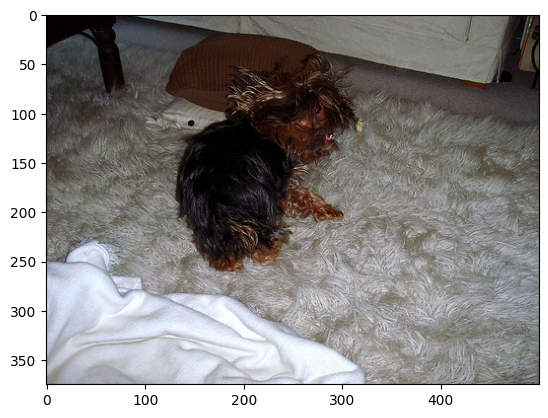

Caption: A black and brown dog is laying on a white shaggy carpet .
Caption: A brown and black dog is laying on a shaggy rug .
Caption: a small brown and black dog lying down in a furry rug .
Caption: A small dog is sitting on white carpet .
Caption: A small dog shakes its head on a white shag carpet .


In [9]:
dataindex = 1000
imgpath = dataloc+'/Images/'+capdf.iloc[dataindex, 0]
img=mpimg.imread(imgpath)
plt.imshow(img)
plt.show()
for i in range(dataindex,dataindex + 5):
    print("Caption:",capdf.iloc[i,1])

In [10]:
class Vocabulary:
    def __init__(self, fthresh):
        self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.stoi = {i:j for j, i in self.itos.items()}
        self.fthresh = fthresh
    def __len__(self):
        return len(self.itos)
    #Possible need for static due to additions and no change in tokenization policy
    @staticmethod
    def tokenize(text):
        return [i.text.lower() for i in spacyen.tokenizer(text)]
    def buildvocab(self, sentList):
        freqs = Counter()
        idx = 4
        for s in sentList:
            for word in self.tokenize(s):
                freqs[word] += 1
                if freqs[word] >= self.fthresh:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    def numericalize(self, text):
        tokenizedtext = self.tokenize(text)
        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>'] for token in tokenizedtext]

In [11]:
spacyen = spacy.load('en_core_web_sm')
test = 'DND course is interesting'
print([i.text.lower() for i in spacyen.tokenizer(test)])

['dnd', 'course', 'is', 'interesting']


In [12]:
vtest = Vocabulary(fthresh=1)
vtest.buildvocab(['This is a test sentence'])
print(vtest.itos)
print(vtest.stoi)
print(vtest.numericalize("The test sentence is provided here"))

{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'this', 5: 'is', 6: 'a', 7: 'test', 8: 'sentence'}
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'test': 7, 'sentence': 8}
[3, 7, 8, 5, 3, 3]


In [13]:
class FlickrDataset(Dataset):
    def __init__(self, datadir, captiondir, transform=None, fthresh=5):
        """
        自定义数据集，用于加载 Flickr8k 数据
        - datadir: 包含所有图像的目录路径
        - captiondir: 包含图像标注的 CSV 文件路径
        - transform: 图像预处理函数 (torchvision.transforms.Compose)
        - fthresh: 最小词频阈值，用于构建词汇表
        """
        self.datadir = datadir
        self.df = pd.read_csv(captiondir)  # 加载标注文件
        self.imgs = self.df['image']  # 图像文件名列
        self.captions = self.df['caption']  # 对应的字幕列
        self.vocab = Vocabulary(fthresh)  # 构建词汇表
        self.vocab.buildvocab(self.captions.tolist())

        # 默认 transform 或用户自定义 transform
        self.transform = transform or T.Compose([
            T.Resize((256, 256)),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        """
        返回数据集的样本数量
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        获取图像和字幕数据
        - index: 数据索引
        返回: 图像张量 (C, H, W) 和字幕张量
        """
        # 获取图像路径和对应的字幕
        caption = self.captions[index]
        imgname = self.imgs[index]
        imgloc = os.path.join(self.datadir, imgname)

        # 加载图像并转换为 RGB 格式
        img = Image.open(imgloc).convert('RGB')
        if self.transform:
            img = self.transform(img)  # 应用图像预处理

        # 将字幕转为索引
        capvec = [self.vocab.stoi['<SOS>']]
        capvec += self.vocab.numericalize(caption)
        capvec += [self.vocab.stoi['<EOS>']]

        # 转为张量
        capvec = torch.tensor(capvec, dtype=torch.long)
        return img, capvec


In [14]:
def showimage(img, title=None):
    #denormalization
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #error in updation of plots if removed

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


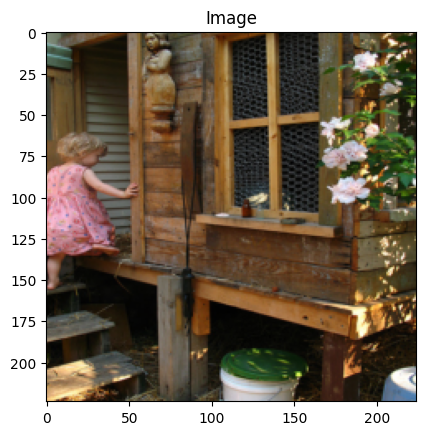

Token: tensor([     1, 457656, 457182, 457646, 457656, 457612, 456374, 457620, 457658,
        457635, 457656, 455820, 457479, 410334, 457646, 457194,      3, 452922,
        457660,      2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [16]:
from torchvision import transforms as T

# 定义图像预处理
image_transforms = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建数据集
dataset = FlickrDataset(
    datadir="/content/flickr8k/Images",  # 图像路径
    captiondir="/content/flickr8k/captions.txt",  # 标注文件路径
    transform=image_transforms  # 传递预处理
)


img, caps = dataset[0]
img = img.cpu()
showimage(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

Example output from dataset class

Split your dataset into train, val and test sets

In [17]:
# ADD YOUR CODE HERE
from sklearn.model_selection import train_test_split

# Split the dataset into train and test
train_df, test_df = train_test_split(capdf, test_size=0.2, random_state=42)

# Further split the train set into train and validation
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Train set size: 24273
Validation set size: 8091
Test set size: 8091


In [18]:
class CapsCollate:
    def __init__(self, padindex, batchfirst=False, max_length=None):
        self.padindex = padindex  # 填充值索引
        self.batchfirst = batchfirst  # 是否返回 batch-first 格式
        self.max_length = max_length  # 最大序列长度

    def __call__(self, batch):
        # 提取批次中的图像和字幕
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)  # 合并图像为张量

        # 将所有字幕移到 GPU 或 CPU，与 imgs 保持一致
        device = imgs.device
        targets = [item[1].to(device) for item in batch]

        if self.max_length is not None:
            targets = [
                caption if len(caption) == self.max_length
                else torch.cat(
                    (
                        caption,
                        torch.full(
                            (self.max_length - len(caption),),
                            self.padindex,
                            dtype=torch.long,
                            device=device
                        )
                    )
                ) if len(caption) < self.max_length else caption[:self.max_length]
                for caption in targets
            ]
        else:
            max_length = max(len(caption) for caption in targets)
            targets = [
                caption if len(caption) == max_length
                else torch.cat(
                    (
                        caption,
                        torch.full(
                            (max_length - len(caption),),
                            self.padindex,
                            dtype=torch.long,
                            device=device
                        )
                    )
                )
                for caption in targets
            ]

        # 合并字幕张量
        targets = torch.stack(targets, dim=0 if self.batchfirst else 1)
        return imgs.to(device), targets


In [19]:
# ADD YOUR CODE HERE
# Example with batch=4
BATCH_SIZE = 16
NUM_WORKER = 0
padindex = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(padindex=padindex ,batchfirst=True)
)

dataiter = iter(data_loader)
batch = next(dataiter)
images, captions = batch
images = images.to(device)
captions = captions.to(device)


In [20]:
from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset

# 定义图像预处理
image_transforms = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建完整数据集
full_dataset = FlickrDataset(
    datadir=dataloc + "/Images",
    captiondir=dataloc + "/captions.txt",
    transform=image_transforms
)

# 根据索引创建训练集、验证集和测试集的子集
train_dataset = Subset(full_dataset, train_df.index.tolist())
val_dataset = Subset(full_dataset, val_df.index.tolist())
test_dataset = Subset(full_dataset, test_df.index.tolist())

# 定义批次大小和其他参数
BATCH_SIZE = 16
NUM_WORKER = 0
padindex = full_dataset.vocab.stoi["<PAD>"]

# 创建数据加载器
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKER,
    collate_fn=CapsCollate(padindex=padindex, batchfirst=True),
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKER,
    collate_fn=CapsCollate(padindex=padindex, batchfirst=True),
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKER,
    collate_fn=CapsCollate(padindex=padindex, batchfirst=True),
    drop_last=True
)


0


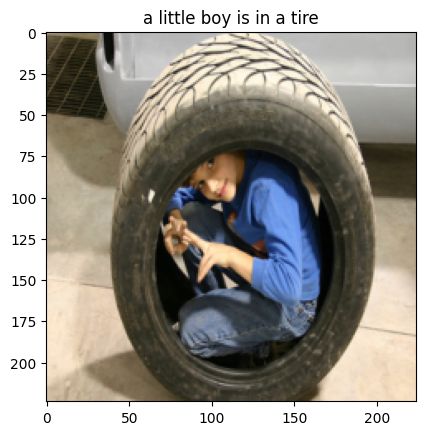

1


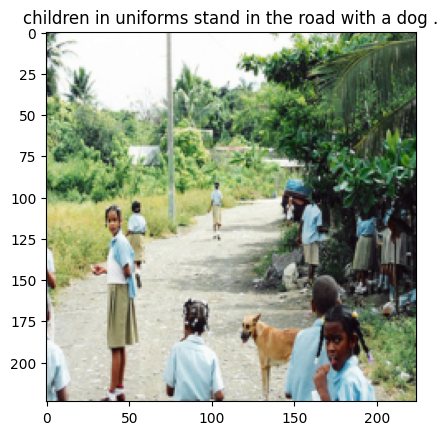

2


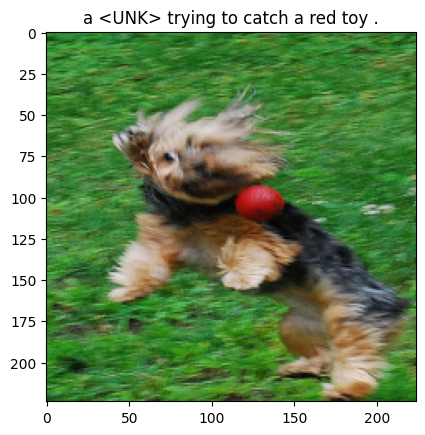

3


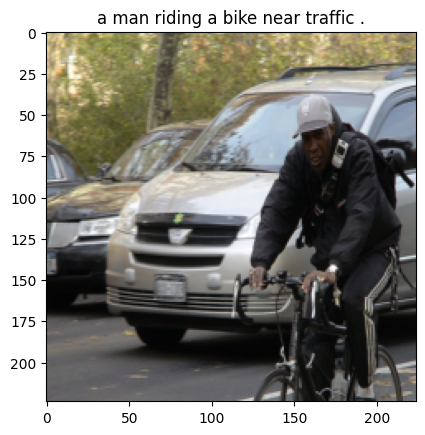

4


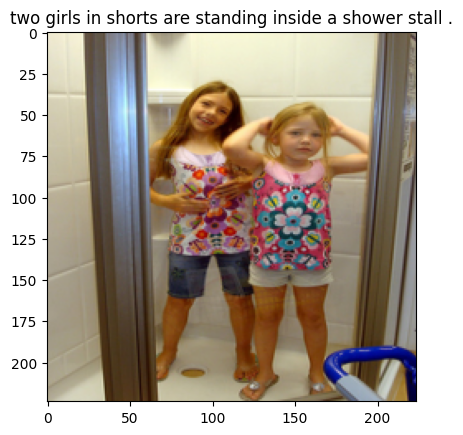

5


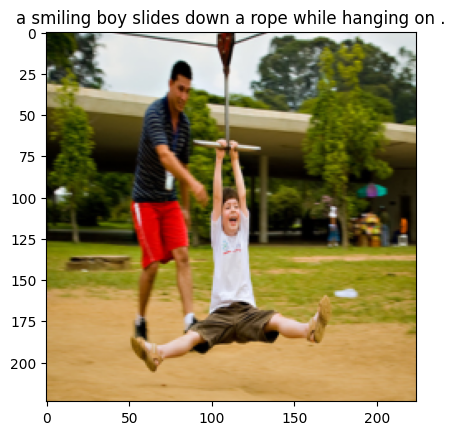

6


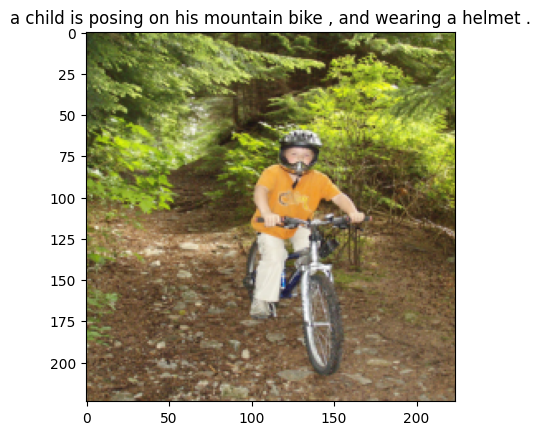

7


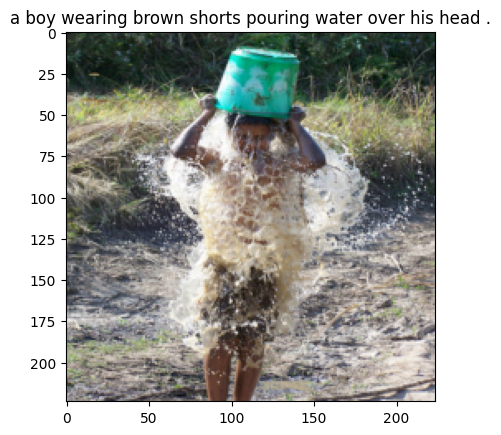

8


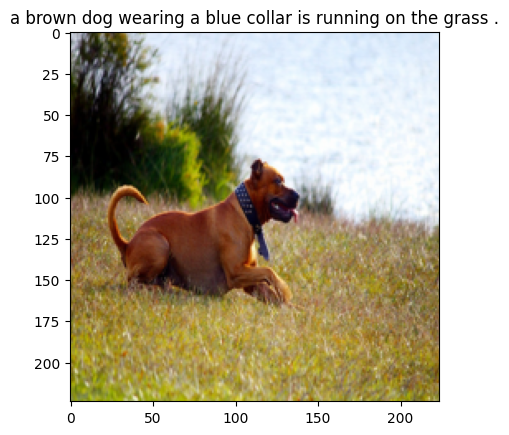

9


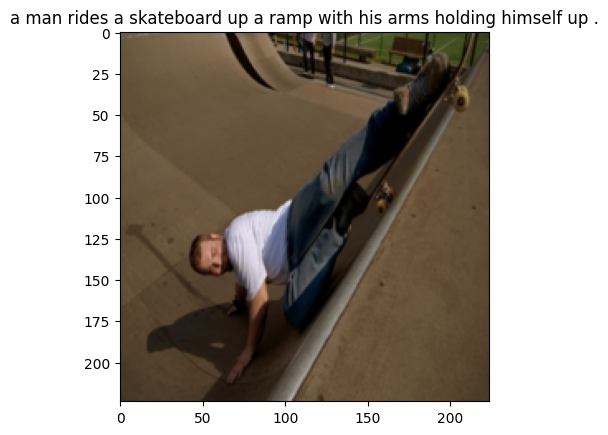

10


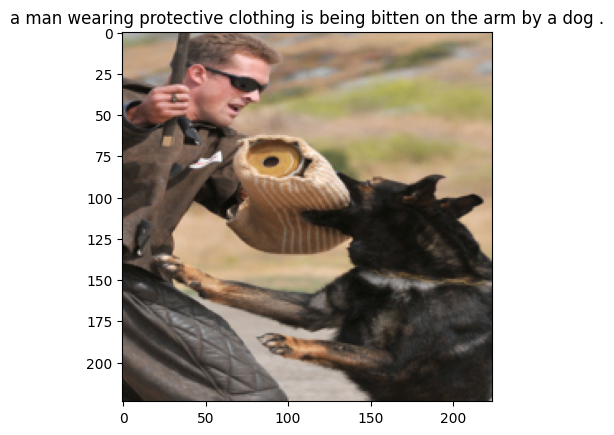

11


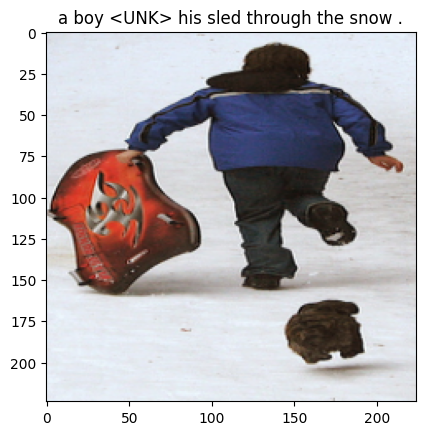

12


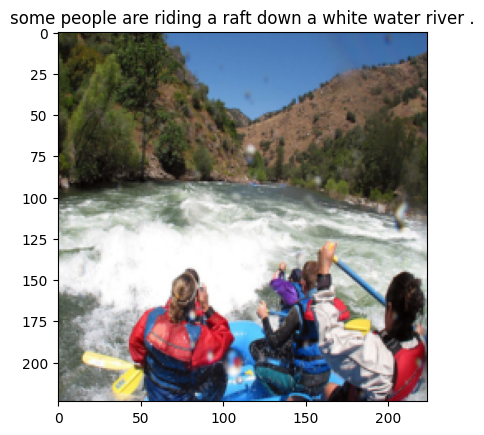

13


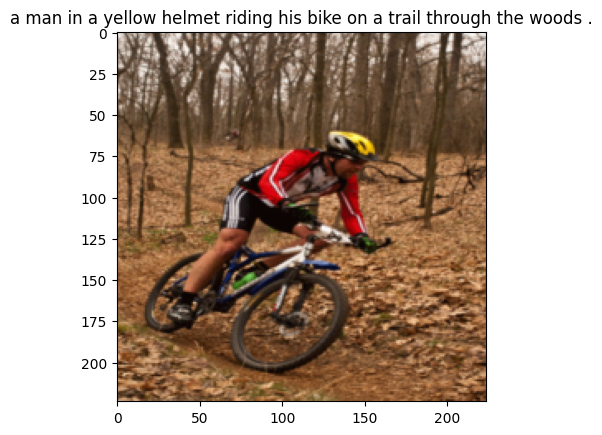

14


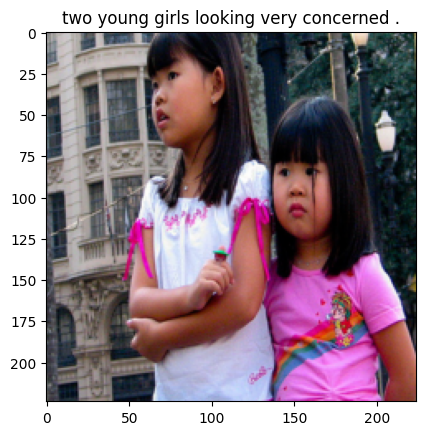

15


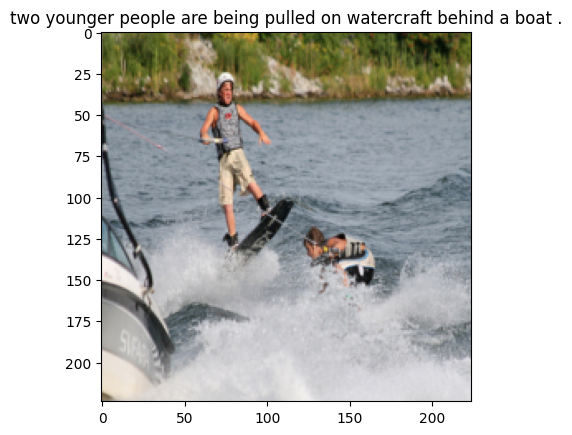

In [21]:
dataiter = iter(data_loader)
batch = next(dataiter)
images, captions = batch
for i in range(BATCH_SIZE):
    print(i)
    img,cap = images[i],captions[i]
    img = img.cpu()
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)
    showimage(img,caption_label)
    plt.show()

#2. MODEL
For this assignment, you are required to create your own custom image captioning model and compare its performance with an existing pre-trained model.

In [22]:
#Make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 2.1. Custom Image Captioning model

Create an Encoder-Attention-Decoder architecture with the following details:
- the encoder should process the images, thus you can create a Convolutional based architecture or use already pre-trained models like ResNet. However, you must fine-tune the pretrained model. The encoder is responisble for extracting image features;
- the attention layer should be between the encoder and decoder. It uses the image features from the encoder in order to provide context (attention scores) to the decoder hidden layers. For simplicity use Linear layers as the attention architecture;
- the decoder should be a sequence based model (i.e. LSTM) in order to process and generate captions.

Extra:
- Extra points (counting toward the final grade) will be given to any student who implements either a Vision-based Transformer architecture or a Transformer only decoder for the decoder part.

#### Reference
Here is an example of something similar to what we want to create:
<img src="https://drive.google.com/thumbnail?id=1wdddaLit7iEyCcVy5bS505NiYzL6c-4x&sz=w1000">


In [23]:
import torch
import torch.nn as nn
from transformers import ViTModel, ViTFeatureExtractor
import math
import time
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

# Encoder: 使用 Vision Transformer
class EncoderViT(nn.Module):
    def __init__(self, embed_dim):
        super(EncoderViT, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        # 冻结部分ViT层以防止过拟合
        for param in list(self.vit.parameters())[:-4]:
            param.requires_grad = False
        self.fc = nn.Linear(self.vit.config.hidden_size, embed_dim)
        self.dropout = nn.Dropout(0.1)  # 添加dropout

    def forward(self, images):
        outputs = self.vit(pixel_values=images)
        encoder_features = self.dropout(self.fc(outputs.last_hidden_state))
        return encoder_features

# Attention Mechanism
class Attention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attention_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(enc_dim, attention_dim)
        self.U = nn.Linear(dec_dim, attention_dim)
        self.A = nn.Linear(attention_dim, 1)
        self.dropout = nn.Dropout(0.1)  # 添加dropout

    def forward(self, encoder_features, hidden_state):
        uhs = self.U(hidden_state)
        wah = self.W(encoder_features)
        combined = torch.tanh(uhs.unsqueeze(1) + wah)
        combined = self.dropout(combined)  # 应用dropout
        attention_scores = self.A(combined).squeeze(2)
        alpha = torch.softmax(attention_scores, dim=1)
        attention_weights = (encoder_features * alpha.unsqueeze(2)).sum(dim=1)
        return alpha, attention_weights

# Decoder: Transformer Decoder
class DecoderTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_len, enc_dim, attention_dim):
        super(DecoderTransformer, self).__init__()

        # 基础层
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding_dropout = nn.Dropout(0.1)  # 专门的嵌入层dropout
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))

        # 教师强制参数
        self.teacher_forcing_ratio = 1.0
        self.min_teacher_forcing_ratio = 0.2  # 提高最小教师强制比例

        # 增强的注意力层
        self.self_attention = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads, dropout=0.1)
            for _ in range(num_layers)
        ])
        self.cross_attention = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads, dropout=0.1)
            for _ in range(num_layers)
        ])

        # 前馈网络
        self.feed_forward = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, 4 * embed_dim),
                nn.GELU(),  # 使用GELU替代ReLU
                nn.Dropout(0.1),
                nn.Linear(4 * embed_dim, embed_dim),
                nn.Dropout(0.1)
            ) for _ in range(num_layers)
        ])

        # Layer Normalization
        self.norm1 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])
        self.norm2 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])
        self.norm3 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])

        # 输出层
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(0.2)

        # 注意力机制
        self.attention = Attention(enc_dim=enc_dim, dec_dim=embed_dim, attention_dim=attention_dim)

    def update_teacher_forcing_ratio(self, epoch, total_epochs):
        # 使用更温和的余弦退火
        ratio = 0.5 * (1.0 + math.cos(math.pi * epoch / (2 * total_epochs)))
        self.teacher_forcing_ratio = max(self.min_teacher_forcing_ratio, ratio)

    def generate_attention_mask(self, seq_len):
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        return mask.masked_fill(mask == 1, float('-inf'))

    def forward(self, encoder_features, captions, tgt_mask=None):
        batch_size, seq_len = captions.size()

        # 1. 词嵌入和位置编码
        x = self.embedding_dropout(self.embedding(captions))
        x = self.dropout(x + self.positional_encoding[:, :seq_len, :])

        # 2. 注意力掩码
        if tgt_mask is None:
            tgt_mask = self.generate_attention_mask(seq_len).to(captions.device)

        # 3. 多层Transformer处理
        for i in range(len(self.self_attention)):
            # Self-Attention
            residual = x
            attn_output, _ = self.self_attention[i](
                query=x.transpose(0, 1),
                key=x.transpose(0, 1),
                value=x.transpose(0, 1),
                attn_mask=tgt_mask
            )
            x = self.norm1[i](residual + self.dropout(attn_output.transpose(0, 1)))

            # Cross-Attention
            residual = x
            cross_attn_output, _ = self.cross_attention[i](
                query=x.transpose(0, 1),
                key=encoder_features.transpose(0, 1),
                value=encoder_features.transpose(0, 1)
            )
            x = self.norm2[i](residual + self.dropout(cross_attn_output.transpose(0, 1)))

            # Feed-Forward
            residual = x
            x = self.norm3[i](residual + self.feed_forward[i](x))

        # 4. 计算注意力
        hidden_state = x[:, -1, :]
        alpha, _ = self.attention(encoder_features, hidden_state)

        # 5. 输出层
        output = self.fc_out(x)

        return output, alpha

# 完整的 Encoder-Decoder 模型
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, enc_dim, attention_dim, num_heads, num_layers, max_len):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderViT(embed_dim=enc_dim)
        self.decoder = DecoderTransformer(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            max_len=max_len,
            enc_dim=enc_dim,
            attention_dim=attention_dim,
        )

    def forward(self, images, captions, tgt_mask=None):
        encoder_features = self.encoder(images)
        outputs, alphas = self.decoder(encoder_features, captions, tgt_mask)
        return outputs, alphas

    def generate_caption(self, images, max_len, sos_token, eos_token, vocab, beam_size=3):
        """使用集束搜索生成描述"""
        encoder_features = self.encoder(images)
        beams = [(torch.tensor([sos_token]).unsqueeze(0).to(images.device), 0.0)]
        completed_beams = []

        for _ in range(max_len):
            candidates = []
            for seq, score in beams:
                if seq[-1].item() == eos_token:
                    completed_beams.append((seq, score))
                    continue

                outputs, _ = self.decoder(encoder_features, seq)
                logits = outputs[:, -1, :]
                probs = torch.log_softmax(logits, dim=-1)
                values, indices = probs[0].topk(beam_size)

                for value, index in zip(values, indices):
                    new_seq = torch.cat([seq, index.unsqueeze(0).unsqueeze(0)], dim=1)
                    new_score = score + value.item()
                    candidates.append((new_seq, new_score))

            if not candidates:
                break

            # 选择最好的beam_size个候选
            beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]

        completed_beams.extend(beams)  # 添加未完成的序列
        best_seq = max(completed_beams, key=lambda x: x[1])[0]

        return [vocab.itos[idx.item()] for idx in best_seq[0]], None

Combine the encoder - attention - decoder

### 2.2. Training custom model

In [37]:
# 模型参数
vocab_size = len(dataset.vocab)
embed_dim = 768
enc_dim = 768
attention_dim = 384  # 减小注意力维度
num_heads = 8       # 减少注意力头数
num_layers = 6      # 减少层数
max_len = 80
learning_rate = 2e-5  # 降低学习率
num_epochs = 25
warmup_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = ImageCaptioningModel(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    enc_dim=enc_dim,
    attention_dim=attention_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    max_len=max_len
).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss(
    ignore_index=dataset.vocab.stoi["<PAD>"],
    label_smoothing=0.1
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.1,
    betas=(0.9, 0.98)
)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='linear',
    final_div_factor=10
)

Epoch [1/25], Batch [50/1517], Loss: 12.7401, LR: 0.000001
Epoch [1/25], Batch [100/1517], Loss: 12.2816, LR: 0.000001
Epoch [1/25], Batch [150/1517], Loss: 11.5436, LR: 0.000002
Epoch [1/25], Batch [200/1517], Loss: 10.9797, LR: 0.000002
Epoch [1/25], Batch [250/1517], Loss: 10.5760, LR: 0.000002
Epoch [1/25], Batch [300/1517], Loss: 10.2947, LR: 0.000002
Epoch [1/25], Batch [350/1517], Loss: 9.9745, LR: 0.000003
Epoch [1/25], Batch [400/1517], Loss: 9.6410, LR: 0.000003
Epoch [1/25], Batch [450/1517], Loss: 9.4330, LR: 0.000003
Epoch [1/25], Batch [500/1517], Loss: 9.0197, LR: 0.000003
Epoch [1/25], Batch [550/1517], Loss: 8.9002, LR: 0.000004
Epoch [1/25], Batch [600/1517], Loss: 9.2349, LR: 0.000004
Epoch [1/25], Batch [650/1517], Loss: 8.8825, LR: 0.000004
Epoch [1/25], Batch [700/1517], Loss: 8.7460, LR: 0.000004
Epoch [1/25], Batch [750/1517], Loss: 8.2497, LR: 0.000005
Epoch [1/25], Batch [800/1517], Loss: 7.6797, LR: 0.000005
Epoch [1/25], Batch [850/1517], Loss: 7.6603, LR: 0

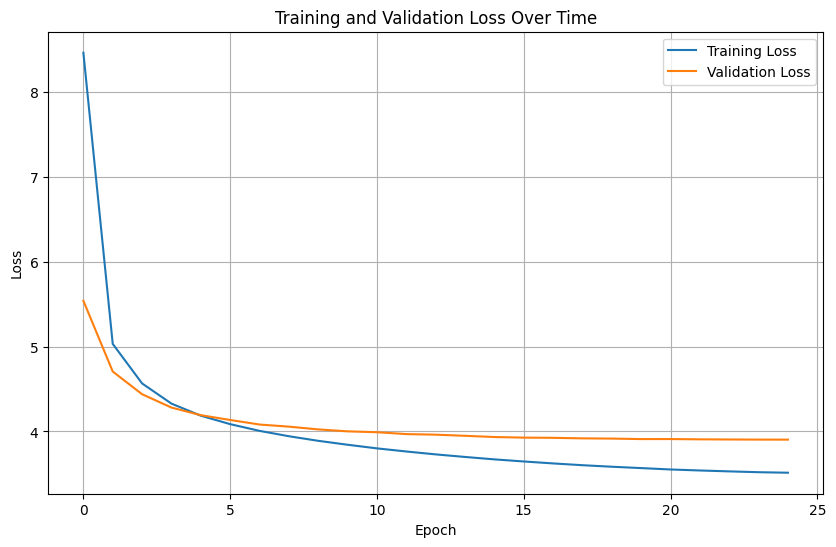

In [38]:
# 初始化 GradScaler用于混合精度训练
scaler = GradScaler(device='cuda')

def train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, epoch, num_epochs, log_interval=10):
    """训练一个epoch
    参数:
    - model: 图像描述模型
    - train_loader: 训练数据加载器
    - optimizer: 优化器
    - criterion: 损失函数
    - device: 训练设备
    - scaler: 用于混合精度训练的GradScaler
    - epoch: 当前epoch
    - num_epochs: 总epoch数
    - log_interval: 打印日志的间隔
    """
    model.train()  # 设置为训练模式
    total_loss = 0
    start_time = time.time()

    # 更新教师强制比例,随着训练进行逐渐减少教师强制
    model.decoder.update_teacher_forcing_ratio(epoch, num_epochs)

    # 遍历训练批次
    for batch_idx, (images, captions) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        # 使用梯度累积来增加等效批量大小
        accumulation_steps = 2  # 累积2步相当于翻倍batch size
        optimizer.zero_grad()  # 清空梯度

        batch_loss = 0  # 记录当前批次的累积损失

        for _ in range(accumulation_steps):
            # 使用混合精度训练
            with autocast(device_type='cuda'):
                # 前向传播,去掉目标序列的最后一个token
                outputs, _ = model(images, captions[:, :-1])
                outputs = outputs.permute(0, 2, 1)  # 调整维度顺序以匹配CrossEntropyLoss要求
                # 计算损失,使用去掉开头的目标序列作为标签
                loss = criterion(outputs, captions[:, 1:])
                # 将损失除以累积步数
                loss = loss / accumulation_steps

            # 反向传播
            scaler.scale(loss).backward()
            batch_loss += loss.item()

        # 梯度裁剪防止梯度爆炸
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

        # 优化器步进
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  # 更新学习率

        total_loss += batch_loss

        # 定期打印训练信息
        if (batch_idx + 1) % log_interval == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {batch_loss:.4f}, LR: {current_lr:.6f}")

    # 计算平均损失并打印epoch总结
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Finished. "
          f"Avg Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s")
    return avg_loss

def validate(model, val_loader, criterion, device, epoch, num_epochs):
    """验证函数
    用于评估模型在验证集上的表现,不进行梯度计算
    """
    model.eval()  # 设置为评估模式
    total_loss = 0
    start_time = time.time()

    with torch.no_grad():  # 不计算梯度
        for batch_idx, (images, captions) in enumerate(val_loader):
            images = images.to(device)
            captions = captions.to(device)

            # 前向传播
            outputs, _ = model(images, captions[:, :-1])
            outputs = outputs.permute(0, 2, 1)

            # 计算损失
            loss = criterion(outputs, captions[:, 1:])
            total_loss += loss.item()

    # 计算平均损失
    avg_loss = total_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation: "
          f"Avg Loss: {avg_loss:.4f}, Time: {time.time() - start_time:.2f}s")
    return avg_loss

# 训练循环主体
def train(model, train_loader, val_loader, criterion, optimizer, scheduler,
          device, num_epochs, save_path):
    """完整的训练流程
    包含训练、验证、模型保存和早停机制
    """
    best_val_loss = float('inf')  # 记录最佳验证损失
    train_losses = []  # 记录训练损失
    val_losses = []    # 记录验证损失
    early_stopping_patience = 5  # 早停耐心值
    no_improve_count = 0  # 未改善计数器

    # 创建GradScaler用于混合精度训练
    scaler = GradScaler(device='cuda')

    for epoch in range(num_epochs):
        # 训练阶段
        train_loss = train_one_epoch(
            model, train_loader, optimizer, criterion,
            device, scaler, epoch, num_epochs, log_interval=50
        )

        # 验证阶段
        val_loss = validate(
            model, val_loader, criterion,
            device, epoch, num_epochs
        )

        # 记录损失
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # 模型保存逻辑
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0  # 重置未改善计数器
            # 保存完整的检查点
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
            }, save_path)
            print(f"Model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")
        else:
            no_improve_count += 1
            if no_improve_count >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # 打印epoch总结
        print(f"Epoch [{epoch+1}/{num_epochs}] Summary: "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# 可视化训练过程
def plot_training_history(train_losses, val_losses):
    """绘制训练和验证损失曲线"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# 执行训练
save_path = "best_image_captioning_model.pth"
train_losses, val_losses = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs,
    save_path=save_path
)

# 绘制训练历史
plot_training_history(train_losses, val_losses)

In [26]:
from google.colab import files

# 指定文件路径
file_path = "best_image_captioning_model.pth"

# 下载文件到本地
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
def visualize_attention(image, result_caption, attention_plot, vocab, pad_token, eos_token):
    """
    改进版可视化函数，处理 attention_plot 为 1D 的情况
    """
    # 归一化图像
    temp_image = image.cpu().permute(1, 2, 0).numpy()
    temp_image = (temp_image - temp_image.min()) / (temp_image.max() - temp_image.min())

    # 过滤生成的句子，去掉 <PAD> 和 <EOS>
    filtered_caption = [idx for idx in result_caption if idx not in [pad_token, eos_token]]

    # 检查 attention_plot 的维度
    if attention_plot.ndim == 1:
        # 如果是 1D (197,)，剔除 [CLS] Token 并 reshape 为 (14, 14)
        attention_plot = attention_plot[1:].reshape(14, 14)
        attention_plot = np.expand_dims(attention_plot, axis=0)  # 添加 seq_len 维度
    elif attention_plot.ndim == 2:
        # 如果是 2D，直接转换为 (seq_len, 14, 14)
        seq_len, num_patches = attention_plot.shape
        side_length = int(np.sqrt(num_patches))
        attention_plot = attention_plot.reshape(seq_len, side_length, side_length)
    else:
        raise ValueError(f"Unexpected attention_plot shape: {attention_plot.shape}")

    # 创建显示窗口
    fig = plt.figure(figsize=(20, 10))  # 根据需要调整窗口大小

    # 显示原始图像
    ax_main = fig.add_subplot(4, 6, 1)  # 创建主图像子图
    ax_main.imshow(temp_image)
    ax_main.axis('off')  # 不显示坐标轴
    fig.suptitle(' '.join([vocab.itos[idx] for idx in filtered_caption]),
                 fontsize=16, wrap=True)  # 显示生成的句子

    # 显示注意力热力图
    for l, word_index in enumerate(filtered_caption):
        temp_att = attention_plot[min(l, len(attention_plot) - 1)]  # 防止索引越界
        temp_att = (temp_att - temp_att.min()) / (temp_att.max() - temp_att.min())  # 归一化热力图
        ax = fig.add_subplot(4, 6, l + 2)  # 按顺序创建子图
        ax.set_title(vocab.itos[word_index], fontsize=12)  # 显示单词
        ax.imshow(temp_att, cmap='gray')  # 显示注意力热力图
        ax.axis('off')  # 不显示坐标轴

    plt.tight_layout()
    plt.show()


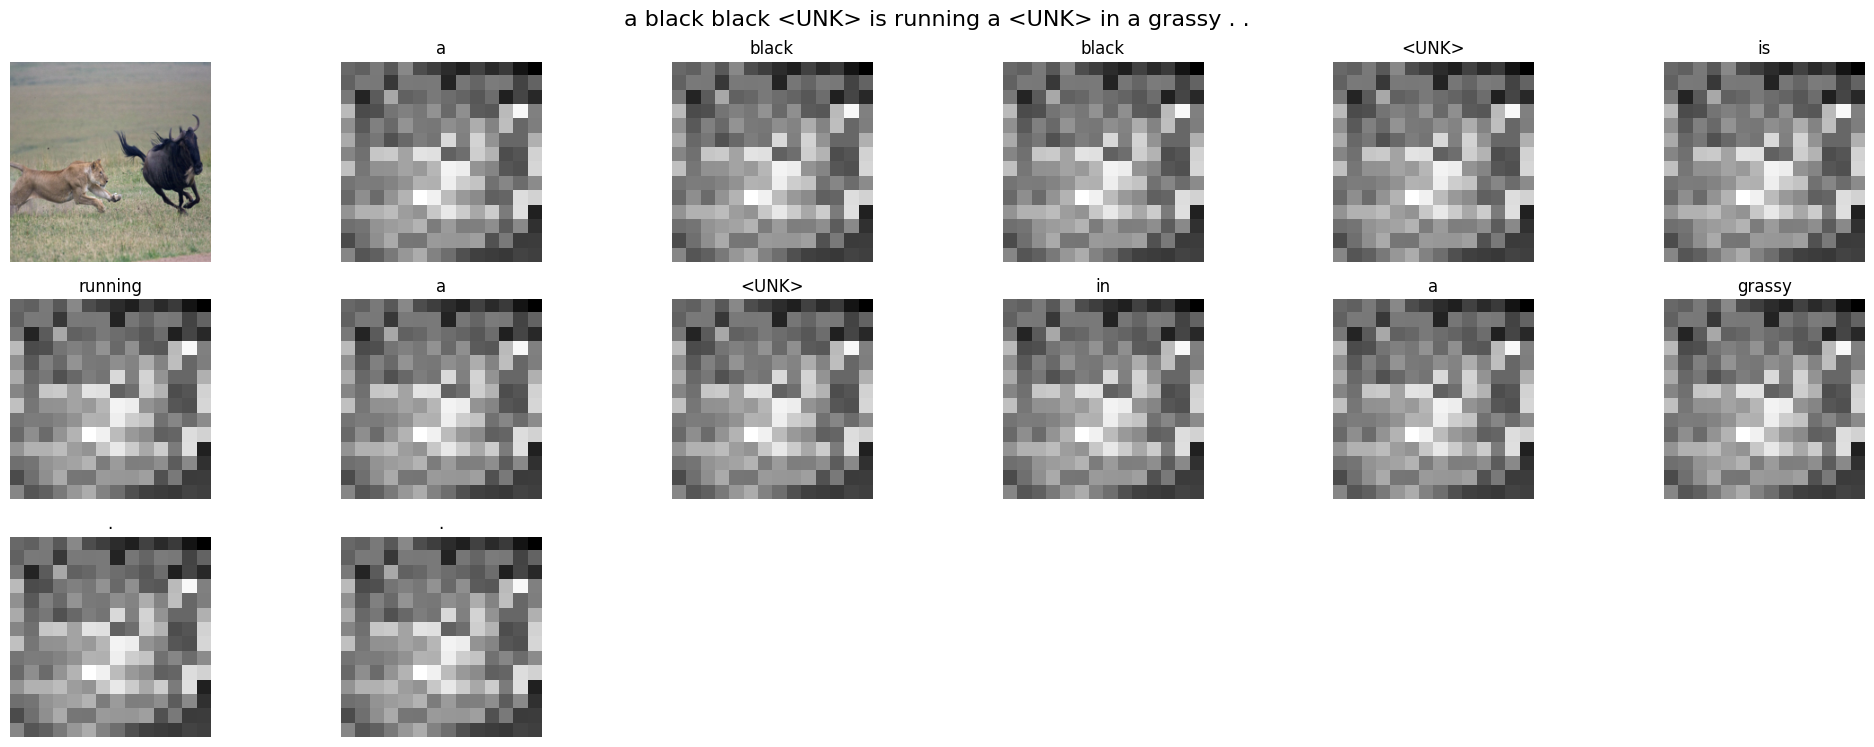

In [41]:
# 从数据加载器中提取一个批次
dataiter = iter(test_loader)  # 假设 test_loader 是测试集的 DataLoader
images, captions = next(dataiter)

# 将数据移动到设备
images = images.to(device)  # 图像数据 [batch_size, C, H, W]
captions = captions.to(device)  # 对应的字幕 [batch_size, seq_len]

# 使用模型进行预测
features = model.encoder(images)  # 提取特征
preds, alphas = model.decoder(features, captions[:, :-1])  # 解码器生成字幕和注意力权重

# 选择一个样本
sample_index = 0
image = images[sample_index]  # 单张图像 (C, H, W)
result_caption = preds[sample_index].argmax(dim=1).tolist()  # 模型生成的字幕索引序列
attention_plot = alphas[sample_index].detach().cpu().numpy()  # 注意力权重

# 获取 <PAD> 和 <EOS> 标记的索引
pad_token = dataset.vocab.stoi["<PAD>"]
eos_token = dataset.vocab.stoi["<EOS>"]

# 调用可视化函数
visualize_attention(image, result_caption, attention_plot, dataset.vocab, pad_token, eos_token)


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import shutil

# 文件路径
src_path = '/content/best_image_captioning_model.pth'
dest_path = '/content/drive/MyDrive/DND_硕士第一学期/DND大作业/best_image_captioning_model.pth'

# 移动文件到 Google Drive
shutil.copy(src_path, dest_path)

print(f"文件已成功复制到：{dest_path}")


文件已成功复制到：/content/drive/MyDrive/DND_硕士第一学期/DND大作业/best_image_captioning_model.pth


In [27]:
import os

# 确认文件是否在目标路径
dest_path = '/content/drive/MyDrive/DND_硕士第一学期/DND大作业/best_image_captioning_model.pth'
print(f"文件是否在目标路径存在: {os.path.exists(dest_path)}")


文件是否在目标路径存在: True


### Important: we recommend saving the model during training, so that you can resume training later in case of any Google Colab issue or limitation

Pay attention to your choices. Define an optimizer, a loss function, the number of epochs and regularization techniques.
Be aware of overfitting and underfitting. Make sure the loss is decreasing over the epochs. Save the losses so that they can be visualized.

Visualize the attention weigths in order to understand how your model learned (**Failure to do this, will result in losing points**).
For that, use the 'context' variable returned by the Attention class to overlay them on the image.

### 2.3. Evaluation on test set

Evaluate your trained model on the test set. Use the BLEU score as your metric: torchtext.data.metrics.bleu_score(...)

You may try **BLEU-1, 2** and **3**.

In [42]:
# 1. 首先定义加载函数
def load_checkpoint(path, model, device):
    """
    加载模型检查点

    参数：
    - path: 检查点文件路径
    - model: 模型实例
    - device: 运行设备

    返回：
    - model: 加载了权重的模型
    - training_info: 训练相关的信息字典
    """
    # 加载检查点
    checkpoint = torch.load(path, map_location=device)

    # 从检查点中获取模型状态字典
    model.load_state_dict(checkpoint['model_state_dict'])

    # 获取训练信息
    training_info = {
        'epoch': checkpoint['epoch'],
        'best_val_loss': checkpoint['best_val_loss'],
        'train_losses': checkpoint['train_losses'],
        'val_losses': checkpoint['val_losses']
    }

    return model, training_info

# 2. 加载模型
try:
    # 确保模型在正确的设备上
    model = model.to(device)

    # 加载检查点
    model, training_info = load_checkpoint(
        path="best_image_captioning_model.pth",
        model=model,
        device=device
    )

    # 设置为评估模式
    model.eval()

    # 打印加载信息
    print(f"模型加载成功！")
    print(f"训练轮次: {training_info['epoch'] + 1}")
    print(f"最佳验证损失: {training_info['best_val_loss']:.4f}")

except Exception as e:
    print(f"加载模型时出错: {str(e)}")

<ipython-input-42-d782ebf6142a>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


模型加载成功！
训练轮次: 25
最佳验证损失: 3.9036


In [43]:
def generate_caption(model, image, vocab, max_len=30):
    model.eval()
    caption = []
    image = image.to(device)
    sos_token = vocab.stoi["<SOS>"]
    eos_token = vocab.stoi["<EOS>"]
    inputs = torch.tensor([[sos_token]], device=device)

    with torch.no_grad():
        encoder_features = model.encoder(image)
        for _ in range(max_len):
            outputs, _ = model.decoder(encoder_features, inputs)
            outputs = outputs[:, -1, :]  # 取最后一个时间步的输出
            predicted_id = outputs.argmax(dim=-1).item()

            if predicted_id == eos_token:  # 如果生成了 <EOS>，停止预测
                break

            # 过滤掉 <PAD> 和 <UNK>
            if predicted_id not in [vocab.stoi["<PAD>"], vocab.stoi["<UNK>"]]:
                caption.append(predicted_id)

            inputs = torch.cat([inputs, torch.tensor([[predicted_id]], device=device)], dim=1)

    return [vocab.itos[idx] for idx in caption]


In [44]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# BLEU 分数计算函数


# BLEU 分数计算函数
def calculate_bleu(reference, hypothesis):
    """
    计算单个句子的 BLEU-1、BLEU-2 和 BLEU-3 分数
    - reference: 参考字幕 (list of list of str, 例如 [["a", "cat", "on", "the", "mat"]])
    - hypothesis: 模型生成的字幕 (list of str, 例如 ["a", "cat", "on", "the", "mat"])
    """
    smooth_fn = SmoothingFunction().method4  # 平滑函数
    bleu_1 = sentence_bleu(reference, hypothesis, weights=(1.0, 0, 0, 0), smoothing_function=smooth_fn)
    bleu_2 = sentence_bleu(reference, hypothesis, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
    bleu_3 = sentence_bleu(reference, hypothesis, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
    return bleu_1, bleu_2, bleu_3



# 测试模型
def test_model(model, test_loader, vocab, max_len=30):
    """
    测试模型，并计算平均 BLEU 分数
    - model: 训练好的模型
    - test_loader: 提供测试集数据的 DataLoader
    - vocab: Vocabulary 对象
    - max_len: 最大生成序列长度
    """
    bleu_scores = []

    model.eval()
    with torch.no_grad():
        for batch_idx, (images, captions) in enumerate(test_loader):
            images = images.to(device)  # 图像张量 [batch_size, C, H, W]
            captions = captions.tolist()  # 转换为列表形式

            for i in range(images.size(0)):  # 遍历 batch 中的每张图像
                image = images[i].unsqueeze(0)  # 单张图像，保持形状 [1, C, H, W]
                reference_caption = [[vocab.itos[idx] for idx in captions[i] if idx not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]]  # 参考字幕

                # 使用模型生成字幕
                generated_caption = generate_caption(model, image, vocab, max_len=max_len)

                # 计算 BLEU 分数
                bleu_score = calculate_bleu(reference_caption, generated_caption)
                bleu_scores.append(bleu_score)

                # 打印结果
                print(f"Reference: {' '.join(reference_caption[0])}")
                print(f"Generated: {' '.join(generated_caption)}")
                print(f"BLEU Score: {bleu_score:.4f}\n")

    # 计算平均 BLEU 分数
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score: {average_bleu:.4f}")


In [45]:
def generate_caption_with_beam_search(model, image, vocab, beam_size=3, max_len=30):
    model.eval()
    image = image.to(device)
    sos_token = vocab.stoi["<SOS>"]
    eos_token = vocab.stoi["<EOS>"]

    with torch.no_grad():
        encoder_features = model.encoder(image)
        sequences = [[[], 0.0]]  # 存储 [序列, 对应分数]

        for _ in range(max_len):
            all_candidates = []
            for seq, score in sequences:
                if len(seq) > 0 and seq[-1] == eos_token:
                    all_candidates.append((seq, score))  # 保留已完成的序列
                    continue

                inputs = torch.tensor([[sos_token] + seq], device=device)
                outputs, _ = model.decoder(encoder_features, inputs)
                outputs = outputs[:, -1, :]  # 取最后一个时间步
                top_k = torch.topk(outputs, beam_size, dim=-1)  # 选取 top-k 候选
                probs, indices = top_k.values, top_k.indices

                for i in range(beam_size):
                    candidate = seq + [indices[0, i].item()]
                    candidate_score = score - torch.log(probs[0, i]).item()  # 取对数概率
                    all_candidates.append((candidate, candidate_score))

            # 保留分数最低的 beam_size 个序列
            sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_size]

        best_sequence = sequences[0][0]  # 分数最低的序列
        return [
            vocab.itos[idx]
            for idx in best_sequence
            if idx not in [sos_token, eos_token, vocab.stoi["<PAD>"]]
        ]


In [46]:
def test_model_with_bleu_scores(model, test_loader, vocab, beam_size=3, max_len=30, max_samples=50):
    """
    测试模型，并计算平均 BLEU-1、BLEU-2 和 BLEU-3 分数
    - model: 训练好的模型
    - test_loader: 提供测试集数据的 DataLoader
    - vocab: 词汇表对象
    - beam_size: Beam Search 的大小
    - max_len: 最大生成序列长度
    - max_samples: 最大测试样本数量
    """
    bleu1_scores, bleu2_scores, bleu3_scores = [], [], []
    model.eval()
    sample_count = 0  # 初始化计数器

    with torch.no_grad():
        for batch_idx, (images, captions) in enumerate(test_loader):
            images = images.to(device)
            captions = captions.tolist()

            for i in range(images.size(0)):
                if sample_count >= max_samples:
                    break  # 达到最大样本数量时停止

                image = images[i].unsqueeze(0)
                reference_caption = [
                    [vocab.itos[idx] for idx in captions[i] if idx not in [vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]]]
                ]

                # 使用 Beam Search 生成字幕
                generated_caption = generate_caption_with_beam_search(model, image, vocab, beam_size=beam_size, max_len=max_len)

                # 计算 BLEU 分数
                bleu_1, bleu_2, bleu_3 = calculate_bleu(reference_caption, generated_caption)
                bleu1_scores.append(bleu_1)
                bleu2_scores.append(bleu_2)
                bleu3_scores.append(bleu_3)

                # 打印结果
                print(f"Sample {sample_count + 1}/{max_samples}")
                print(f"Reference: {' '.join(reference_caption[0])}")
                print(f"Generated: {' '.join(generated_caption)}")
                print(f"BLEU-1: {bleu_1:.4f}, BLEU-2: {bleu_2:.4f}, BLEU-3: {bleu_3:.4f}\n")

                sample_count += 1

            if sample_count >= max_samples:
                break  # 如果达到最大样本数量，则退出外循环

    # 平均 BLEU 分数
    avg_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    avg_bleu2 = sum(bleu2_scores) / len(bleu2_scores)
    avg_bleu3 = sum(bleu3_scores) / len(bleu3_scores)
    print(f"Average BLEU-1 Score (on {max_samples} samples): {avg_bleu1:.4f}")
    print(f"Average BLEU-2 Score (on {max_samples} samples): {avg_bleu2:.4f}")
    print(f"Average BLEU-3 Score (on {max_samples} samples): {avg_bleu3:.4f}")


In [47]:
# 使用 Beam Search 测试模型，输出 BLEU-1、BLEU-2 和 BLEU-3
test_model_with_bleu_scores(model, test_loader, dataset.vocab, beam_size=3, max_len=30, max_samples=50)


Sample 1/50
Reference: a large wild cat is <UNK> a horse across a meadow .
Generated: a black and white dog runs through the grass .
BLEU-1: 0.1637, BLEU-2: 0.0586, BLEU-3: 0.0354

Sample 2/50
Reference: two brown dogs fight on the leafy ground .
Generated: a brown and white dog is playing with a stick in the woods .
BLEU-1: 0.2143, BLEU-2: 0.0660, BLEU-3: 0.0375

Sample 3/50
Reference: a man in shorts is standing on a rock looking out at the view from the <UNK> .
Generated: a man is standing on top of a cliff overlooking the ocean . " with a mountain in the background . " . " . " . " .
BLEU-1: 0.3448, BLEU-2: 0.1922, BLEU-3: 0.1135

Sample 4/50
Reference: a muzzled white dog is running on the grass .
Generated: a white and brown dog is running through the grass with a white ball in its mouth . " . " . . " . " . . "
BLEU-1: 0.2759, BLEU-2: 0.1719, BLEU-3: 0.1054

Sample 5/50
Reference: a person skiing downhill .
Generated: a person in a red jacket is climbing up a snowy mountain . " wi

### 2.4. Load an existing Image Captioning model
Feel free to choose any pre-trained image captioning model. For simplicity, try choosing a model already trained on Flickr8k.

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

### 2.5 Evaluate the chosen pre-trained captioning model on the test set
Use the same metrics chosen on step **2.3**.

In [ ]:
# ADD YOUR CODE HERE
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds


predict_step(['/content/flickr8k/Images/1007320043_627395c3d8.jpg']) # ['a woman in a hospital bed with a woman in a hospital bed']

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

['a little girl that is playing with a toy']

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from PIL import Image
import torch

# BLEU 分数计算函数
def calculate_bleu(reference, hypothesis):
    """
    计算单句子的 BLEU 分数
    - reference: 参考字幕 (list of list of str, [["a", "child", "playing", "on", "a", "rope"]])
    - hypothesis: 模型生成的字幕 (list of str, ["a", "child", "playing", "on", "a", "rope"])
    """
    smooth_fn = SmoothingFunction().method1  # 避免零概率的平滑函数
    return sentence_bleu(reference, hypothesis, smoothing_function=smooth_fn)

# 测试 BLEU 分数计算
reference_captions = [["a", "child", "playing", "on", "a", "rope", "net"]]
generated_caption = ["a", "child", "is", "playing", "on", "a", "rope"]

# 计算 BLEU 分数
bleu_score = calculate_bleu(reference_captions, generated_caption)
print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.4889


# 3. COMPARISON
Compare the performance of the two models using **BLEU-1, 2** and **3**. Show some visualizations of predictions from both models. Justify their differences. How would you improve your own custom model?

The bleu score of my model is relatively low compared to existing models. I think it may be a problem with the model. My model may not be perfect enough. Maybe I can also optimize the structure of the vocabulary and increase the epoch.